# Toy Example

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
from loss_cal.tasks.toy_example import ToyExample
from loss_cal.costs import StepCost_weighted, SigmoidStepCost_weighted
from loss_cal.utils.plot import plot_step_loss
from loss_cal.utils.utils import load_data
from loss_cal.predictor import train, build_nn

plot_config_file = "loss_cal/utils/.matplotlibrc"
color_npe = '#377eb8'
color_nn = '#ff7f00'
color_post = '#4daf4a'
seed =  1 #85403 #2023 #
# tested seeds (using ReLU as activaton)
# 0, 2, 4, 5, 7 - final layer weights mostly negative
# 1, 3, 6, 8 - working

## Set Up

In [3]:
toy = ToyExample(action_type="discrete", num_actions=2)
toy.task_name

'toy_example'

Prior and Simulator

In [4]:
prior = toy.get_prior()
simulator = toy.get_simulator()

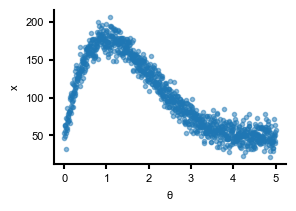

In [5]:
with mpl.rc_context(fname=plot_config_file):
    fig, ax = plt.subplots(1, 1, figsize=(3, 2))
    thetas = torch.linspace(0, 5, 1000)
    ax.scatter(thetas, simulator(thetas), alpha=0.5)
    ax.set_xlabel(r"$\theta$")
    ax.set_ylabel("x")
    #ax.set_title("joint")
    plt.savefig("./results/toy_example/joint.pdf")
        #'results/1d_classifier/1D_clf_joint.pdf')
    plt.show()

Posterior

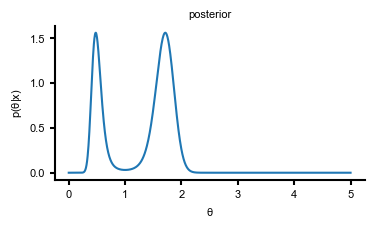

In [6]:
lower = 0
upper = 5
resolution = 1000
x_o = 150
posterior_evals = toy.gt_posterior(torch.Tensor([x_o]))
with mpl.rc_context(fname=plot_config_file):
    fig, ax = plt.subplots(1, 1, figsize=(4, 2))
    thetas = torch.linspace(lower, upper, resolution)
    ax.plot(thetas, posterior_evals)
    ax.set_xlabel(r"$\theta$")
    ax.set_ylabel(r"$p(\theta|x)$")
    ax.set_title("posterior")
    plt.show()

## Binary Actions

### Decision Task

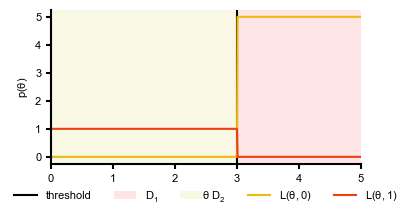

In [7]:
threshold = 3.0
costs = [5.0, 1.0]
cost_fn = StepCost_weighted(costs, threshold=threshold)
plot_step_loss(cost_fn, lower, upper, threshold, resolution=500, plot_config_file=plot_config_file)

### Load data

In [8]:
n_train = 10_000
n_test = 1_000

torch.manual_seed(seed)
theta_train, x_train, theta_val, x_val, theta_test, x_test = load_data("toy_example")
actions_evaluate = toy.actions.sample(x_train.shape[0]).float()
theta_train = theta_train[: n_train]
x_train = x_train[: n_train]
actions_evaluate = actions_evaluate[:n_train]
theta_val = theta_val[: n_test]
x_val = x_val[: n_test]
theta_test = theta_test[: n_test ]
x_test = x_test[: n_test]

print(f"N_train = {theta_train.shape[0]}, N_val = {theta_val.shape[0]}, N_test = {theta_test.shape[0]}")

Load data from './data/toy_example', device = cpu.
N_train = 10000, N_val = 1000, N_test = 1000


### Train a neural network to predict expected costs

In [9]:
nn = build_nn(
    model="fc",
    x_train=x_train,
    action_train=actions_evaluate,
    hidden_dims=[20, 20],
    output_dim=1,
    activation=torch.nn.ReLU(),
    output_transform=torch.nn.ReLU(),
    seed=seed
)
print(nn, end="\n-----\n")
# torch.save(nn.state_dict(), f"./results/toy_example/test/state_dict_{seed}_run{runid}.pt")
#nn.state_dict()

FeedforwardNN(
  (standardize_layer): Standardize()
  (input_layer): Linear(in_features=2, out_features=20, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=20, out_features=20, bias=True)
  )
  (final_layer): Linear(in_features=20, out_features=1, bias=True)
  (activation): ReLU()
  (output_transform): ReLU()
)
-----


In [10]:
# initial predictions without training
nn(x_train[:30], actions_evaluate[:30])
#torch.save(nn.state_dict(), "./results/toy_example/discrete/notebook/checkpoints/initial_state.pt")
#nn.load_state_dict(torch.load("./results/toy_example/discrete/notebook/checkpoints/initial_state_good.pt"))

tensor([[0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0484],
        [0.0000],
        [0.0000],
        [0.0798],
        [0.0000],
        [0.0000],
        [0.0119],
        [0.0000],
        [0.0172],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0697],
        [0.0000],
        [0.0000],
        [0.0827],
        [0.0775],
        [0.0000],
        [0.0644],
        [0.0453],
        [0.0366],
        [0.0166],
        [0.0000],
        [0.0457],
        [0.0166],
        [0.0000]], grad_fn=<ReluBackward0>)

In [11]:
nn, train_loss, val_loss = train(
    model=nn,
    x_train=x_train,
    theta_train=theta_train,
    cost_fn=cost_fn,
    x_val=x_val,
    theta_val=theta_val,
    actions=toy.actions,
    learning_rate=1e-3,
    model_dir="./results/toy_example/discrete/notebook",
    stop_after_epochs=50,
    ckp_interval=1,
    max_num_epochs=200,
    batch_size=500,
    seed = seed, 
)

Subdirectory 'checkpoints' already exists. Delete first if wanted.
Converged after 142 epochs. train_loss = 0.56496112	 last_improvement = 50


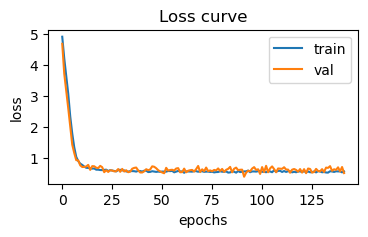

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
ax.plot(train_loss, label="train")
ax.plot(val_loss, label="val")
ax.set_title("Loss curve")
ax.set_xlabel("epochs")
ax.set_ylabel("loss")
ax.legend()
plt.show()

In [13]:
nn(x_train, toy.actions.sample(x_train.shape[0]).float())[:10]


tensor([[4.5802],
        [4.6446],
        [4.7561],
        [4.6896],
        [2.1721],
        [0.0000],
        [0.0000],
        [4.7556],
        [0.0000],
        [0.9756]], grad_fn=<SliceBackward0>)

### Evaluate model

Check predictions on the training data

In [14]:
actions_evaluate = toy.actions.sample(x_train.shape[0]).float()
predictions_train = nn(x_train, actions_evaluate).detach()
true_expected_costs_train = torch.Tensor([toy.expected_posterior_costs(x_o, a, cost_fn=cost_fn, param=0) for x_o, a in zip(x_train, actions_evaluate)]) 

/var/folders/94/0gpvl07x6ks__mzyr78t4gg00006zk/T/ipykernel_5599/4036807675.py:3: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3575.)
  plt.scatter(theta_train[cond].numpy().squeeze(), true_expected_costs_train[cond.T], s=1, c=color_post)


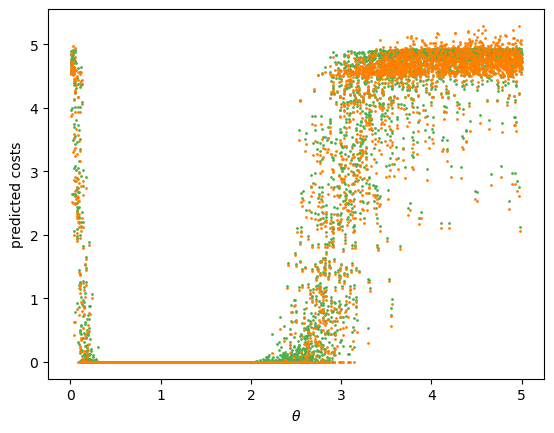

In [15]:
a = 0
cond = (actions_evaluate == a).squeeze()
plt.scatter(theta_train[cond].numpy().squeeze(), true_expected_costs_train[cond.T], s=1, c=color_post)
plt.scatter(theta_train[cond].numpy().squeeze(), predictions_train[cond].numpy().squeeze(), s=1, c=color_nn)
#plt.title(f"a={a}")
plt.xlabel(r"$\theta$")
plt.ylabel("predicted costs")
plt.show()

In [16]:
# MSE
print(
    f"MSE for expected costs given a={a}: {((predictions_train.squeeze() - true_expected_costs_train)**2).mean():.6f}"
)

MSE for expected costs given a=0: 0.004748


Check posterior ratios on training data

In [17]:
expected_costs0 = torch.vstack(
    [toy.expected_posterior_costs(x=x, a=torch.zeros((1, 1)), cost_fn=cost_fn, param=0) for x in x_train]
)
expected_costs1 = torch.vstack(
    [toy.expected_posterior_costs(x=x, a=torch.ones((1, 1)), cost_fn=cost_fn, param=0) for x in x_train]
)

In [18]:
predictions_train0 = nn(x_train, torch.zeros((x_train.shape[0], 1))).detach()
predictions_train1 = nn(x_train, torch.ones((x_train.shape[0], 1))).detach()

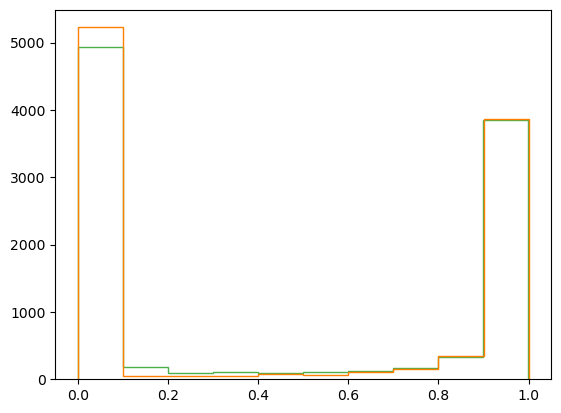

In [19]:
plt.hist((expected_costs0 / (expected_costs0 + expected_costs1)).numpy(), histtype="step", color=color_post)
plt.hist((predictions_train0 / (predictions_train0 + predictions_train1)).numpy(), histtype="step", color=color_nn)

plt.show()

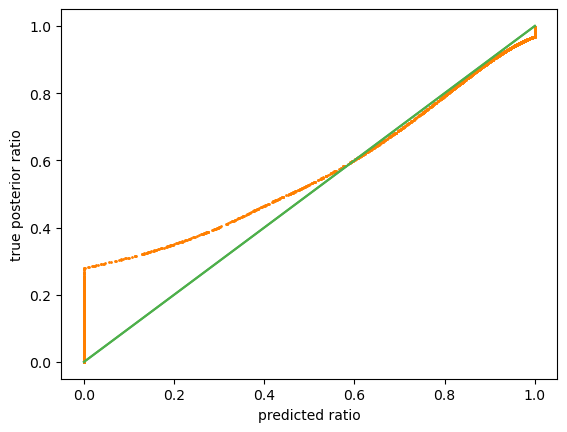

In [20]:
plt.plot([(0, 0), (1, 1)], c=color_post)
plt.scatter(
    (predictions_train0 / (predictions_train0 + predictions_train1)).numpy(),
    (expected_costs0 / (expected_costs0 + expected_costs1)).numpy(),
    s=1,
    c=color_nn,
)
plt.xlabel("predicted ratio")
plt.ylabel("true posterior ratio")
plt.show()

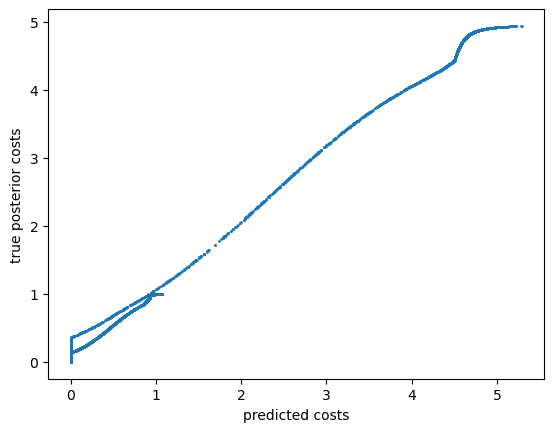

In [21]:

plt.scatter(predictions_train.numpy(), true_expected_costs_train.numpy(), s=1)
plt.xlabel("predicted costs")
plt.ylabel("true posterior costs")
plt.show()